In [5]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
tfb = tfp.bijectors

def plot_confidence_ellipses(multi_norm):
    num_ellipse = multi_norm.mean().shape[0]
    for i in range(num_ellipse):
        mean = multi_norm.mean()[i]
        cov_matrix = tf.linalg.diag(multi_norm.variance()[i]**2).numpy()
        w, v = np.linalg.eig(cov_matrix)
        angle = np.degrees(np.arctan2(v[1, 0], v[0, 0]))
        ellipse = Ellipse(xy=mean, width=np.sqrt(w[0]), height=np.sqrt(w[1]), angle=angle, alpha=0.4)
        plt.gca().add_artist(ellipse)
        ellipse.set_facecolor('blue')
        
def plot_true_posterior(true_posterior):
    # plt.gca().set_aspect('equal', 'box')
    mean = true_posterior.mean()
    cov_matrix = true_posterior.covariance().numpy()
    w, v = np.linalg.eig(cov_matrix)
    angle = np.degrees(np.arctan2(v[1, 0], v[0, 0]))
    ellipse = Ellipse(xy=mean, width=np.sqrt(w[0]), height=np.sqrt(w[1]), angle=angle, alpha=0.6)
    plt.gca().add_artist(ellipse)
    ellipse.set_facecolor('red')

In [3]:
# Generate true posterior distribution
true_mean = [1., -1.]
true_cov = [[0.5, 0.3], [0.3, 0.5]]
true_posterior = tfp.distributions.MultivariateNormalFullCovariance(
    loc=true_mean,
    covariance_matrix=true_cov
)

# Generate family of normal distributions to approximate posterior
num_components = 20
family_mean = tf.Variable(tf.random.normal([num_components, 2]))
family_var = tfp.util.TransformedVariable(
    tf.cast(tf.fill([num_components, 2], np.log(np.exp(1) - 1)), dtype=tf.float32),
    tfb.Softplus()
)
# samples_before = family.sample(1000)
family = tfp.distributions.MultivariateNormalDiag(
    loc=family_mean,
    scale_diag=family_var
)

Instructions for updating:
`MultivariateNormalFullCovariance` is deprecated, use `MultivariateNormalTriL(loc=loc, scale_tril=tf.linalg.cholesky(covariance_matrix))` instead.


2023-03-02 13:30:04.900759: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:967] could not open file to read NUMA node: /sys/bus/pci/devices/0000:04:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-02 13:30:04.901029: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-02 13:30:04.901131: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-02 13:30:04.901170: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-02 13:30:04.901216: W tensorf

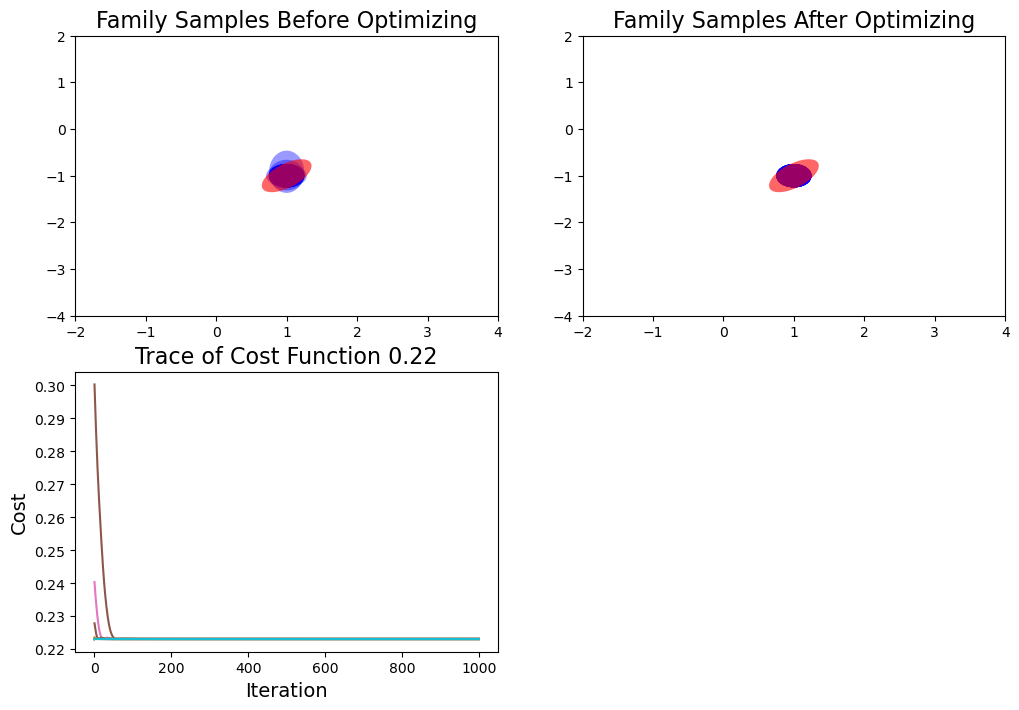

In [6]:
# Plot results
plt.figure(figsize=(12, 8),dpi=100)

# Plot family samples before optimizing
plt.subplot(2,2,1)
# plt.scatter(samples_before[:, 0], samples_before[:, 1])
plot_confidence_ellipses(family)
plot_true_posterior(true_posterior)
# x, y = np.meshgrid(np.linspace(-2, 4, 100), np.linspace(-4, 2, 100))
# xy = np.column_stack([x.flatten(), y.flatten()])
# z = np.exp(true_posterior.log_prob(xy))
# z = np.reshape(z, (100, 100))
# plt.contour(x, y, z, colors='r')
plt.xlim([-2, 4])
plt.ylim([-4, 2])
plt.title("Family Samples Before Optimizing",fontsize=16)


# Define loss function as KL divergence between true posterior and approximating family
def kl_divergence(posterior, approximating_family):
    return tfp.distributions.kl_divergence(posterior, approximating_family)

# Optimize family parameters to minimize KL divergence
num_iterations = 1000
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
costs = []

for i in range(num_iterations):
    with tf.GradientTape() as tape:
        cost = kl_divergence(true_posterior, family)
        costs.append(cost)
    gradients = tape.gradient(cost, [family_mean, family_var.trainable_variables[0]])
    optimizer.apply_gradients(zip(gradients, [family_mean, family_var.trainable_variables[0]]))


plt.subplot(2,2,2)
# plt.scatter(samples_after[:, 0], samples_after[:, 1])
plot_confidence_ellipses(family)
plot_true_posterior(true_posterior)
# plt.contour(x, y, z, colors='r')
plt.xlim([-2, 4])
plt.ylim([-4, 2])
plt.title("Family Samples After Optimizing",fontsize=16)

# Plot trace of cost function after each iteration
plt.subplot(2,2,3)
plt.plot(range(num_iterations), costs)
plt.xlabel("Iteration",fontsize=14)
plt.ylabel("Cost",fontsize=14)
plt.title("Trace of Cost Function %.2f" % tf.reduce_mean(costs[-1]), fontsize=16)
plt.show()